In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = 'retina'
%reload_ext lab_black

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
import seaborn as sns
import logging

FORMAT = "%(asctime)s %(message)s"

logging.basicConfig(level="INFO", format=FORMAT, datefmt="%d-%b-%y %H:%M:%S")
sns.set_context("talk")

In [3]:
from src.load_data import load_data

epoch_key = "remy", 36, 2

data = load_data(epoch_key)

01-Jun-20 13:12:23 Failed to load file: /data2/edeno/replay_trajectory_paper/src/../Raw-Data/Remy/remyDIO36.mat
01-Jun-20 13:12:23 No DIO file found, using distance from well to segment trials
01-Jun-20 13:12:24 Failed to load file: /data2/edeno/replay_trajectory_paper/src/../Raw-Data/Remy/remyDIO36.mat
01-Jun-20 13:12:24 No DIO file found, inferring correct inbound/outbound from task rules
01-Jun-20 13:12:52 Finding ripple times...
01-Jun-20 13:16:00 Failed to load file: /data2/edeno/replay_trajectory_paper/src/../Raw-Data/Remy/remyDIO36.mat
01-Jun-20 13:16:00 No DIO file found, using distance from well to segment trials
01-Jun-20 13:16:01 Failed to load file: /data2/edeno/replay_trajectory_paper/src/../Raw-Data/Remy/remyDIO36.mat
01-Jun-20 13:16:01 No DIO file found, inferring correct inbound/outbound from task rules


In [4]:
from src.parameters import ANIMALS
from loren_frank_data_processing.position import (
    make_track_graph,
    EDGE_ORDER,
    EDGE_SPACING,
)

track_graph, center_well_id = make_track_graph(epoch_key, ANIMALS)
is_running = data["position_info"].speed > 4

In [ ]:
from replay_trajectory_classification import ClusterlessClassifier

from sklearn.model_selection import KFold
from tqdm.auto import tqdm

classifier_parameters = {
    'movement_var': 6.0,
    'replay_speed': 1,
    'place_bin_size': 2.5,
    'continuous_transition_types': [['random_walk', 'uniform'],
                                    ['uniform',     'uniform']],
    'model_kwargs': {
        'bandwidth': np.array([20.0, 20.0, 20.0, 20.0, 8.0])}

}

discrete_state_transition = np.array([[0.968, 0.032],
                                      [0.032, 0.968]])


cv = KFold()
cv_classifier_clusterless_results = []

for fold_ind, (train, test) in tqdm(enumerate(cv.split(data["position_info"].index))):

    cv_classifier = ClusterlessClassifier(**classifier_parameters)

    cv_classifier.fit(
        position=data["position_info"].iloc[train].linear_position,
        multiunits=data["multiunit"].isel(time=train),
        is_training=is_running.iloc[train],
        track_graph=track_graph,
        center_well_id=center_well_id,
        edge_order=EDGE_ORDER,
        edge_spacing=EDGE_SPACING,
    )
    cv_classifier.discrete_state_transition_ = discrete_state_transition
    logging.info('Predicting posterior...')
    cv_classifier_clusterless_results.append(
        cv_classifier.predict(
            data["multiunit"].isel(time=test),
            time=data["position_info"].iloc[test].index / np.timedelta64(1, "s"),
        )
    )
    
    if fold_ind == 0:
        break
logging.info('Done...')

01-Jun-20 15:40:57 Fitting initial conditions...
01-Jun-20 15:40:57 Fitting state transition...
01-Jun-20 15:40:57 Fitting multiunits...
01-Jun-20 15:40:59 Predicting posterior...


In [47]:
import matplotlib.animation as animation
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib.collections import LineCollection
from matplotlib.colorbar import ColorbarBase, make_axes


def get_n_bins(position, bin_size=2.5, position_range=None):
    """Get number of bins need to span a range given a bin size.

    Parameters
    ----------
    position : ndarray, shape (n_time,)
    bin_size : float, optional

    Returns
    -------
    n_bins : int

    """
    if position_range is not None:
        extent = np.diff(position_range, axis=1).squeeze()
    else:
        extent = np.ptp(position, axis=0)
    return np.ceil(extent / bin_size).astype(np.int)


def plot_hex_pair(position_marks, tetrode_key=None):
    """Plot unnormalized hexagonal bin histogram of marks vs. 2D position.

    Parameters
    ----------
    position_marks : pd.DataFrame
    tetrode_key : tuple

    Returns
    -------
    plot_handle : sns.PairGrid instance

    """
    g = sns.PairGrid(position_marks.drop(columns=["head_direction", "speed"]))
    g = g.map_diag(plt.hist, edgecolor="w")
    g = g.map_upper(plt.hexbin, gridsize=20, bins="log")
    g = g.map_lower(plt.hexbin, gridsize=20, bins="log")
    g.fig.suptitle(tetrode_key, size=16)
    g.fig.subplots_adjust(top=0.95)
    return g


def plot_firing_rate(
    position_info,
    position_marks,
    x_name="x_position",
    y_name="channel_1_max",
    sampling_frequency=1500,
    ax=None,
):
    """Plot the firing rate of mark dimension vs. x_position or y_position.

    This is normalized by occupancy.

    Parameters
    ----------
    position_info : pd.DataFrame
        DataFrame containing all positions of the animal.
    position_marks : pd.DataFrame
        DataFrame containing positions of the animal at a particular mark.
    x_name : str
    y_name : str
    sampling_frequency : float, optional
    ax : plt.axis or None

    Returns
    -------
    mesh : `matplotlib.collections.QuadMesh`

    """
    ax = ax or plt.gca()
    x = position_info.loc[:, x_name].values
    n_bins = get_n_bins(x, bin_size=2.8)
    occupancy, x_edges = np.histogram(x, bins=n_bins)

    r = (position_marks.min().min(), position_marks.max().max())
    y = position_marks.loc[:, y_name].values
    n_bins = get_n_bins(y, bin_size=2.8)
    y_edges = np.histogram_bin_edges(y, bins=n_bins, range=r)
    n, x_edges, y_edges = np.histogram2d(
        position_marks.loc[:, x_name].values,
        position_marks.loc[:, y_name].values,
        bins=(x_edges, y_edges),
    )
    occupancy = occupancy.astype(np.float) + np.spacing(1)
    firing_rate = sampling_frequency * n / occupancy[:, np.newaxis]

    mesh = ax.pcolormesh(x_edges, y_edges, firing_rate.T, vmin=0, vmax=5)
    ax.set_xlim(x_edges[0], x_edges[-1])
    ax.set_ylim(y_edges[0], y_edges[-1])
    return mesh


def plot_all_firing_rates(position_info, position_marks, tetrode_key=None):
    """Plot the firing rate of mark dimension vs. x_position or y_position for
    all mark dimensions.

    This is normalized by occupancy.

    Parameters
    ----------
    position_info : pd.DataFrame
        DataFrame containing all positions of the animal.
    position_marks : pd.DataFrame
        DataFrame containing positions of the animal at a particular mark.
    tetrode_key : tuple

    Returns
    -------
    fig : plt.figure instance

    """
    multiunit_names = [
        "channel_1_max",
        "channel_2_max",
        "channel_3_max",
        "channel_4_max",
    ]
    n_marks = len(multiunit_names)

    fig, axes = plt.subplots(
        2, 4, figsize=(n_marks * 4, 2 * 4), constrained_layout=True
    )

    names = pd.MultiIndex.from_product(
        (["x_position", "y_position"], multiunit_names)
    ).tolist()

    for ax, (x_name, y_name) in zip(axes.flat, names):
        h = plot_firing_rate(
            position_info, position_marks, x_name=x_name, y_name=y_name, ax=ax
        )
        ax.set_xlabel(x_name)
        ax.set_ylabel(y_name)
        plt.colorbar(h, ax=ax)
    plt.suptitle(tetrode_key, y=1.04, fontsize=16)

    return fig


def plot_scatter(position_marks):
    g = sns.pairplot(position_marks.drop(columns=["head_direction", "speed"]))
    return g


def plot_2d_glm_fit(
    position, spikes, sampling_frequency, centers_shape, place_field, is_training=None
):
    if is_training is None:
        is_training = np.ones((position.shape[0],), dtype=np.bool)
    is_training = np.asarray(is_training).squeeze()
    position = np.asarray(position)
    spikes = np.asarray(spikes)

    fig, axes = plt.subplots(
        1, 3, figsize=(21, 7), sharex=True, sharey=True, constrained_layout=True
    )
    plot_spikes(position[is_training], spikes[is_training], ax=axes[0])
    plot_hexbin_intensity(
        position[is_training],
        spikes[is_training],
        sampling_frequency,
        centers_shape,
        ax=axes[1],
    )
    plot_glm_rate(place_field, sampling_frequency, position[is_training], ax=axes[2])

    return fig


def plot_spikes(position, spikes, ax=None):
    position_at_spike = position[spikes > 0]
    ax = ax or plt.gca()
    ax.plot(position[:, 0], position[:, 1], color="lightgrey")
    ax.scatter(
        position_at_spike[:, 0], position_at_spike[:, 1], color="red", zorder=100, s=2
    )
    ax.set_title("Spikes")


def plot_hexbin_intensity(position, spikes, sampling_frequency, centers_shape, ax=None):
    position_at_spike = position[spikes > 0]
    ax = ax or plt.gca()
    extent = (
        position[:, 0].min(),
        position[:, 0].max(),
        position[:, 1].min(),
        position[:, 1].max(),
    )
    occupancy = ax.hexbin(
        position[:, 0], position[:, 1], gridsize=centers_shape, extent=extent
    )

    place_bin_spike = ax.hexbin(
        position_at_spike[:, 0],
        position_at_spike[:, 1],
        gridsize=centers_shape,
        extent=extent,
    )
    ax.clear()

    offsets = occupancy.get_offsets()
    occupancy = occupancy.get_array().astype(float)
    place_bin_spike = place_bin_spike.get_array().astype(float)
    rate = sampling_frequency * place_bin_spike / occupancy
    rate[np.isclose(occupancy, 0.0)] = 0.0
    h = ax.hexbin(
        offsets[:, 0],
        offsets[:, 1],
        C=rate,
        reduce_C_function=np.sum,
        gridsize=centers_shape,
        vmin=0.0,
        vmax=np.percentile(rate, 99.5),
        extent=extent,
    )
    plt.colorbar(h, ax=ax, label="spikes / s")
    ax.plot(position[:, 0], position[:, 1], color="lightgrey", alpha=0.3)
    ax.set_title("Histogram Rate Estimate")


def plot_glm_rate(place_field, sampling_frequency, position, ax=None):
    ax = ax or plt.gca()
    ax.plot(position[:, 0], position[:, 1], color="lightgrey", alpha=0.3)
    firing_rate = (place_field * sampling_frequency).unstack()
    firing_rate.plot(
        x="x_position",
        y="y_position",
        ax=ax,
        vmin=0.0,
        vmax=np.percentile(firing_rate, 99.5),
    )
    ax.set_title("GLM Rate Estimate")


def plot_likelihood(
    time_ind, x_edges, y_edges, likelihood, position_info, spikes, time_slice
):
    fig, axes = plt.subplots(1, 2, figsize=(12, 6), constrained_layout=True)
    c = axes[0].pcolormesh(
        x_edges, y_edges, likelihood[time_ind].reshape(x_edges.shape), vmax=1.0
    )
    plt.colorbar(c, ax=axes[0])
    axes[0].plot(
        position_info.x_position, position_info.y_position, color="lightgrey", alpha=0.1
    )
    axes[0].plot(
        position_info.iloc[time_slice].x_position,
        position_info.iloc[time_slice].y_position,
        color="white",
        alpha=0.3,
    )
    axes[0].scatter(
        position_info.x_position.values[time_ind],
        position_info.y_position.values[time_ind],
        zorder=100,
        color="red",
        s=80,
    )
    axes[0].set_ylabel("y-position")
    axes[0].set_xlabel("x-position")
    axes[0].set_title("Likelihood")

    axes[1].bar(np.arange(spikes.shape[1]), spikes[time_ind])
    axes[1].set_xlabel("neuron_ind")
    axes[1].set_xlim((-0.1, spikes.shape[1] + 0.1))
    axes[1].set_ylim((0, 1.5))
    axes[1].get_yaxis().set_visible(False)
    axes[1].spines["top"].set_visible(False)
    axes[1].spines["right"].set_visible(False)
    axes[1].spines["left"].set_visible(False)
    axes[1].set_title("Spikes")
    plt.suptitle(
        f"time = {position_info.index[time_ind].total_seconds():.03f}",
        y=1.04,
        fontsize=16,
    )


def make_movie(
    position,
    posterior_density,
    position_info,
    map_position,
    spikes,
    place_field_max,
    movie_name="video_name.mp4",
):
    # Set up formatting for the movie files
    Writer = animation.writers["ffmpeg"]
    writer = Writer(fps=15, metadata=dict(artist="Me"), bitrate=1800)

    fig, ax = plt.subplots(1, 1, figsize=(7, 7))
    plot_all_positions(position_info, ax=ax)

    ax.set_xlim(position_info.x_position.min() - 1, position_info.x_position.max() + 1)
    ax.set_ylim(position_info.y_position.min() + 1, position_info.y_position.max() + 1)
    ax.set_xlabel("x-position")
    ax.set_ylabel("y-position")

    position_dot = plt.scatter(
        [], [], s=80, zorder=102, color="b", label="actual position"
    )
    (position_line,) = plt.plot([], [], "b-", linewidth=3)
    map_dot = plt.scatter([], [], s=80, zorder=102, color="r", label="decoded position")
    (map_line,) = plt.plot([], [], "r-", linewidth=3)
    spikes_dot = plt.scatter([], [], s=40, zorder=104, color="k", label="spikes")
    vmax = np.percentile(posterior_density.values, 99)
    ax.legend()
    posterior_density.isel(time=0).plot(
        x="x_position", y="y_position", vmin=0.0, vmax=vmax, ax=ax
    )
    n_frames = posterior_density.shape[0]

    def _update_plot(time_ind):
        start_ind = max(0, time_ind - 5)
        time_slice = slice(start_ind, time_ind)

        position_dot.set_offsets(position[time_ind])
        position_line.set_data(position[time_slice, 0], position[time_slice, 1])

        map_dot.set_offsets(map_position[time_ind])
        map_line.set_data(map_position[time_slice, 0], map_position[time_slice, 1])

        spikes_dot.set_offsets(place_field_max[spikes[time_ind] > 0])

        im = posterior_density.isel(time=time_ind).plot(
            x="x_position",
            y="y_position",
            vmin=0.0,
            vmax=vmax,
            ax=ax,
            add_colorbar=False,
        )

        return position_dot, im

    movie = animation.FuncAnimation(
        fig, _update_plot, frames=n_frames, interval=50, blit=True
    )
    if movie_name is not None:
        movie.save(movie_name, writer=writer)

    return fig, movie


def plot_2D_position_with_color_time(
    time, position, ax=None, cmap="plasma", alpha=None
):
    """

    Parameters
    ----------
    time : ndarray, shape (n_time,)
    position : ndarray, shape (n_time, 2)
    ax : None or `matplotlib.axes.Axes` instance
    cmap : str
    alpha : None or ndarray, shape (n_time,)

    Returns
    -------
    line : `matplotlib.collections.LineCollection` instance
    ax : `matplotlib.axes.Axes` instance

    """
    if ax is None:
        ax = plt.gca()
    points = position.reshape(-1, 1, 2)
    segments = np.concatenate([points[:-1], points[1:]], axis=1)

    # Create a continuous norm to map from data points to colors
    norm = plt.Normalize(time.min(), time.max())
    cmap = plt.get_cmap(cmap)
    colors = cmap(norm(time))
    if alpha is not None:
        colors[:, -1] = alpha
    lc = LineCollection(segments, colors=colors, zorder=100)
    lc.set_linewidth(3)
    line = ax.add_collection(lc)

    # Set the values used for colormapping
    cax, _ = make_axes(ax, location="bottom")
    cbar = ColorbarBase(
        cax, cmap=cmap, norm=norm, spacing="proportional", orientation="horizontal"
    )
    cbar.set_label("time")

    return line, ax


def plot_all_positions(position_info, ax=None):
    if ax is None:
        ax = plt.gca()
    ax.plot(
        position_info.x_position.values,
        position_info.y_position.values,
        color="lightgrey",
        alpha=0.5,
        label="all positions",
    )


def plot_posterior_summed_over_time(posterior_density, **plt_kws):
    return posterior_density.sum("time").plot(x="x_position", y="y_position", **plt_kws)


def plot_posterior_time_slices(
    posterior_density, position_info, n_skipped=10, **plt_kws
):
    grid = posterior_density.isel(time=slice(0, -1, n_skipped)).plot(
        x="x_position", y="y_position", col="time", **plt_kws
    )
    for ax in grid.axes.flat:
        plot_all_positions(position_info, ax=ax)

    return grid


def plot_likelihood_with_mean_time(likelihood, spikes):
    spike_time_ind, _ = np.nonzero(np.asarray(spikes))
    spike_time_ind = np.unique(spike_time_ind)
    return (
        likelihood.isel(time=spike_time_ind)
        .mean("time")
        .plot(x="x_position", y="y_position")
    )


def plot_likelihood_time_slices_at_spike(likelihood, spikes, position_info, **plt_kws):
    spike_time_ind, _ = np.nonzero(np.asarray(spikes))
    spike_time_ind = np.unique(spike_time_ind)
    try:
        grid = likelihood.isel(time=spike_time_ind).plot(
            x="x_position", y="y_position", col="time", **plt_kws
        )
        for ax in grid.axes.flat:
            plot_all_positions(position_info, ax=ax)
    except ValueError:
        grid = likelihood.isel(time=spike_time_ind).plot(
            x="x_position", y="y_position", **plt_kws
        )
        plot_all_positions(position_info, ax=grid.axes)

    return grid


def plot_classifier_time_slice(
    time_slice,
    classifier,
    results,
    data,
    posterior_type="acausal_posterior",
    figsize=(30, 20),
):

    t = data["position_info"].index / np.timedelta64(1, "s")
    cmap = plt.cm.viridis
    cmap.set_bad("white", alpha=0.0)

    fig, axes = plt.subplots(
        4,
        1,
        figsize=figsize,
        sharex=True,
        constrained_layout=True,
        gridspec_kw={"height_ratios": [3, 1, 1, 1]},
    )

    # ax 0
    (
        results[posterior_type]
        .sum("state", skipna=False)
        .sel(time=time_slice)
        .plot(x="time", y="position", robust=True, ax=axes[0], cmap=cmap, vmin=0.0,)
    )

    axes[0].set_ylabel("Position [cm]")

    axes[0].set_title("Posterior")

    axes[0].plot(
        data["position_info"].reset_index().set_index(t).loc[time_slice].index,
        data["position_info"]
        .reset_index()
        .set_index(t)
        .loc[time_slice]
        .linear_position,
        color="white",
        linestyle="--",
        linewidth=5,
        alpha=0.8,
    )
    axes[0].set_xlabel("")

    # ax 1
    results[posterior_type].sum("position").sel(time=time_slice).plot(
        x="time", hue="state", ax=axes[1],
    )
    axes[1].set_title("Probability")
    axes[1].set_ylabel("Probability")
    axes[1].set_xlabel("")

    # ax 2
    multiunit_firing = (
        data["multiunit_firing_rate"]
        .reset_index(drop=True)
        .set_index(data["multiunit_firing_rate"].index / np.timedelta64(1, "s"))
    )

    axes[2].fill_between(
        multiunit_firing.loc[time_slice].index.values,
        multiunit_firing.loc[time_slice].values.squeeze(),
        color="black",
    )
    axes[2].set_ylabel("Firing Rate\n[spikes / s]")
    axes[2].set_title("Multiunit")

    # ax 3
    axes[3].fill_between(
        data["position_info"].reset_index().set_index(t).loc[time_slice].index,
        data["position_info"]
        .reset_index()
        .set_index(t)
        .loc[time_slice]
        .speed.values.squeeze(),
        color="lightgrey",
        linewidth=1,
        alpha=0.5,
    )
    axes[3].set_ylabel("Speed [cm / s]")
    axes[3].set_xlabel("Time [s]")
    sns.despine()

In [28]:
cv_classifier_clusterless_results[0].time

<xarray.DataArray 'time' (time: 129671)>
array([1802.750933, 1802.752933, 1802.754933, ..., 2062.086933, 2062.088933,
       2062.090933])
Coordinates:
  * time     (time) float64 1.803e+03 1.803e+03 ... 2.062e+03 2.062e+03

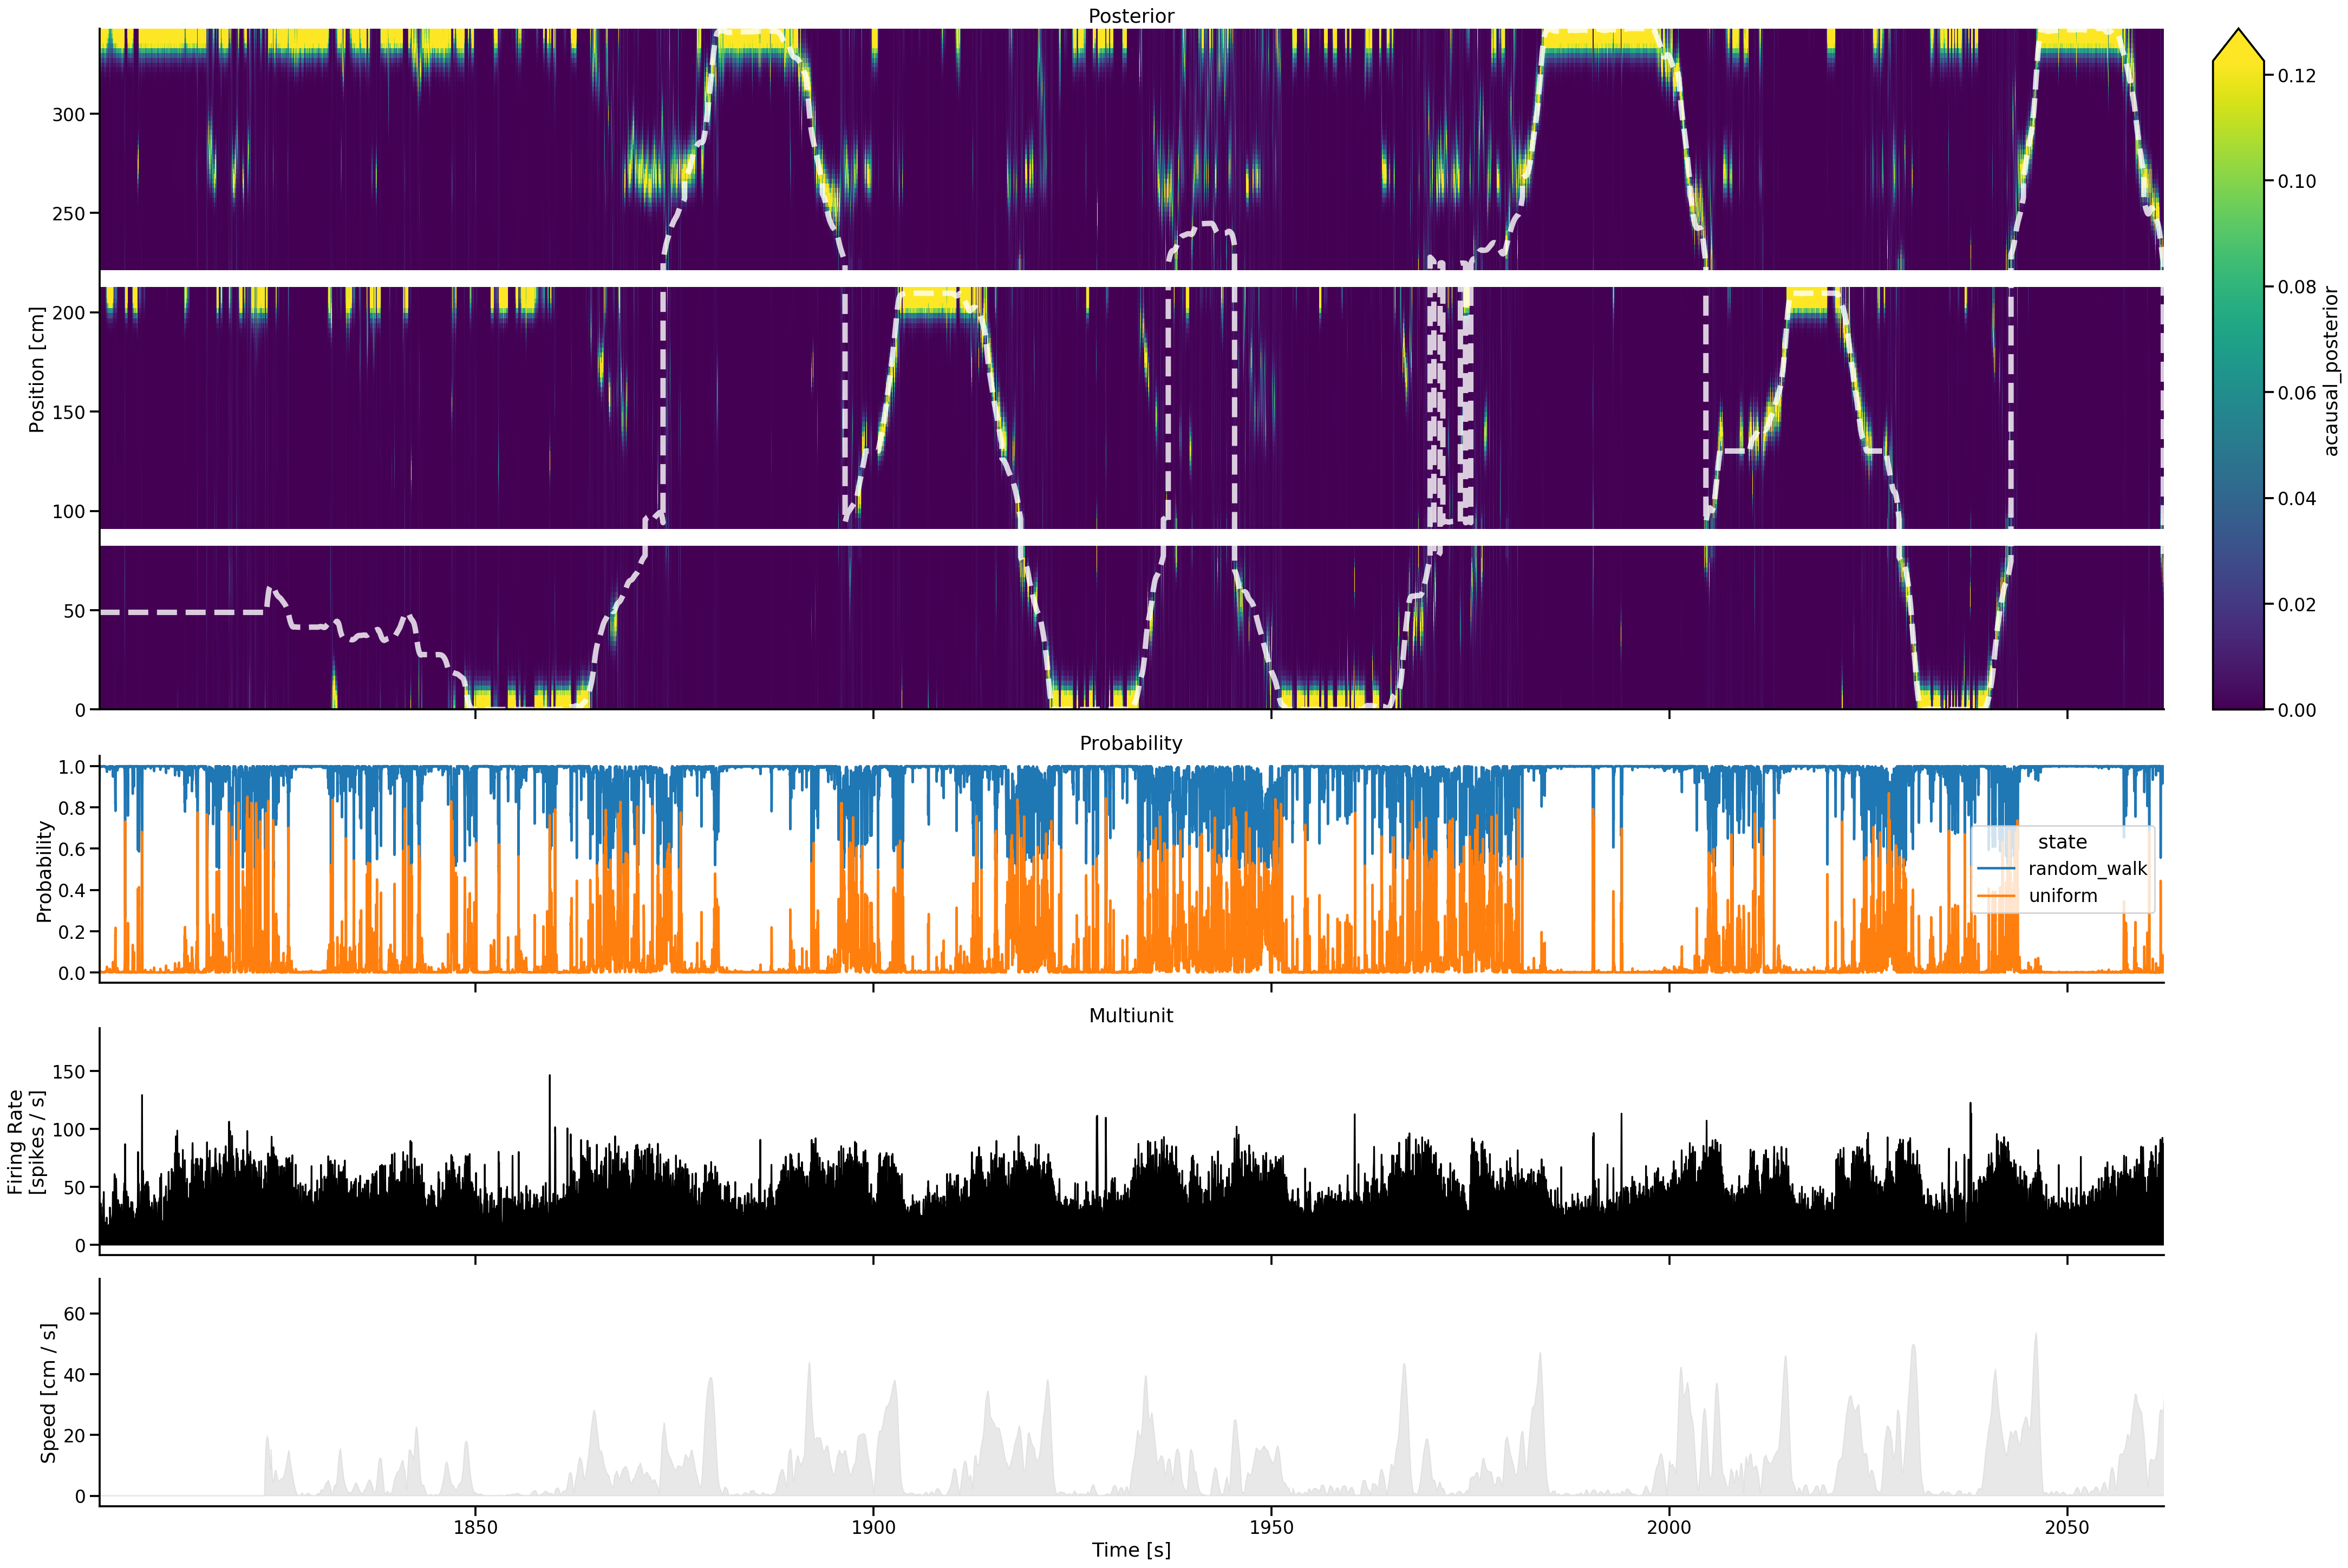

In [35]:
time_slice = slice(0, 100_000)

plot_classifier_time_slice(
    time_slice,
    cv_classifier,
    cv_classifier_clusterless_results[0],
    data,
    posterior_type="acausal_posterior",
    figsize=(30, 20),
)

(2040, 2048)

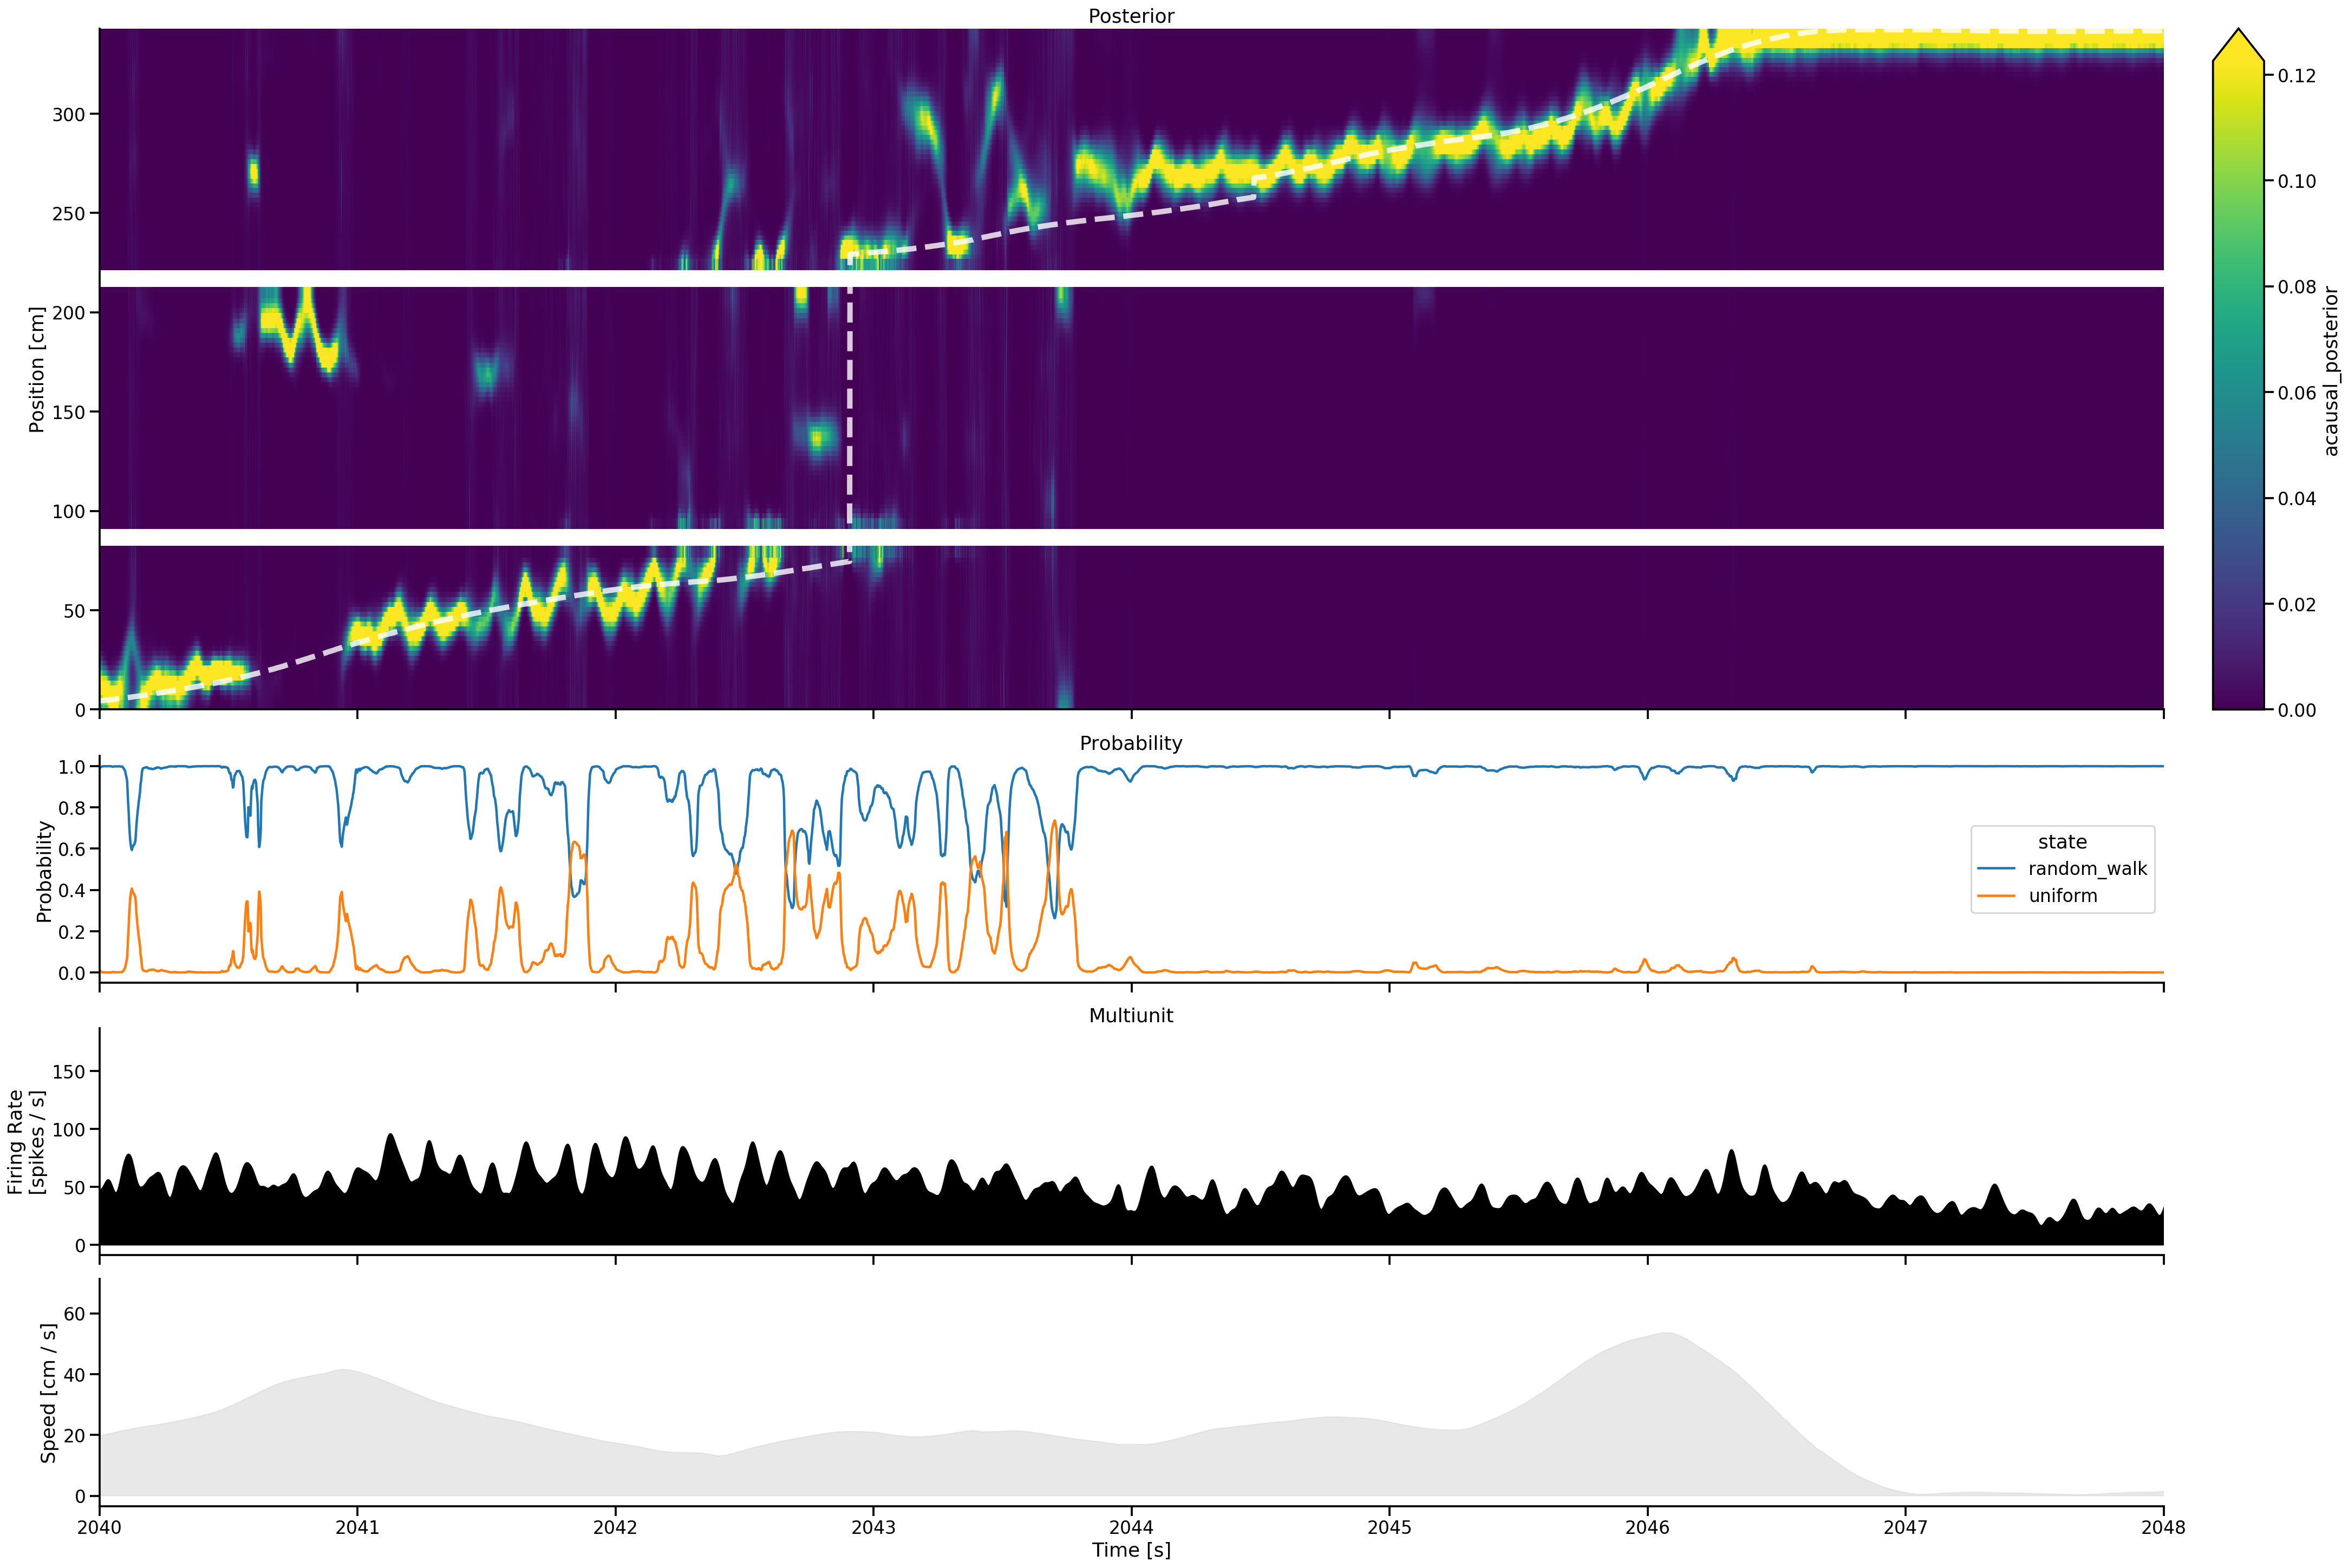

In [38]:
time_slice = slice(0, 80_000)

plot_classifier_time_slice(
    time_slice,
    cv_classifier,
    cv_classifier_clusterless_results[0],
    data,
    posterior_type="acausal_posterior",
    figsize=(30, 20),
)

plt.xlim((2040, 2048))

In [19]:
cv_classifier_clusterless_results[0]

<xarray.Dataset>
Dimensions:            (position: 130, state: 2, time: 129671)
Coordinates:
  * time               (time) float64 1.803e+03 1.803e+03 ... 2.062e+03
  * position           (position) float64 1.235 3.705 6.175 ... 339.2 341.6
  * state              (state) <U11 'random_walk' 'uniform'
Data variables:
    likelihood         (time, state, position) float64 0.8107 0.7972 ... 1.0
    causal_posterior   (time, state, position) float64 0.0048 ... 0.001873
    acausal_posterior  (time, state, position) float64 0.0001299 ... 0.001873

In [52]:
import matplotlib.animation as animation
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from matplotlib.collections import LineCollection
from matplotlib.colorbar import ColorbarBase, make_axes


def make_movie(
    position, map_position, position_info, frame_rate=500, movie_name="video_name.mp4"
):
    # Set up formatting for the movie files
    Writer = animation.writers["ffmpeg"]
    writer = Writer(fps=frame_rate, metadata=dict(artist="Me"), bitrate=1800)

    fig, ax = plt.subplots(1, 1, figsize=(7, 7))
    ax.set_facecolor("black")
    position_2d = position_info.loc[:, ["x_position", "y_position"]]
    ax.plot(
        position_2d.values[:, 0],
        position_2d.values[:, 1],
        color="lightgrey",
        alpha=0.4,
        zorder=1,
    )

    ax.set_xlim(position_info.x_position.min() - 1, position_info.x_position.max() + 1)
    ax.set_ylim(position_info.y_position.min() + 1, position_info.y_position.max() + 1)
    ax.set_xlabel("x-position")
    ax.set_ylabel("y-position")

    position = np.asarray(position)
    position_dot = plt.scatter([], [], s=80, zorder=102, color="b", label="Actual")
    (position_line,) = plt.plot([], [], "b-", linewidth=3)
    sns.despine()
    map_dot = plt.scatter([], [], s=80, zorder=102, color="r", label="Decoded")
    (map_line,) = plt.plot([], [], "r-", linewidth=3)
    ax.legend(fontsize=9, loc="upper right")
    n_frames = map_position.shape[0]

    def _update_plot(time_ind):
        start_ind = max(0, time_ind - 5)
        time_slice = slice(start_ind, time_ind)

        position_dot.set_offsets(position[time_ind])
        position_line.set_data(position[time_slice, 0], position[time_slice, 1])

        map_dot.set_offsets(map_position[time_ind])
        map_line.set_data(map_position[time_slice, 0], map_position[time_slice, 1])

        return position_dot, map_dot

    movie = animation.FuncAnimation(
        fig, _update_plot, frames=n_frames, interval=1000 / frame_rate, blit=True
    )
    if movie_name is not None:
        movie.save(movie_name, writer=writer)

    return fig, movie


def plot_classifier_time_slice(
    time_slice,
    classifier,
    results,
    data,
    posterior_type="acausal_posterior",
    figsize=(30, 20),
):

    t = data["position_info"].index / np.timedelta64(1, "s")
    cmap = plt.cm.viridis
    cmap.set_bad("white", alpha=0.0)

    fig, axes = plt.subplots(
        nrows=4,
        ncols=1,
        figsize=figsize,
        sharex=True,
        constrained_layout=True,
        gridspec_kw={"height_ratios": [3, 1, 1, 1]},
    )

    # ax 0
    (
        results[posterior_type]
        .sum("state", skipna=False)
        .sel(time=time_slice)
        .plot(x="time", y="position", robust=True, ax=axes[0], cmap=cmap, vmin=0.0,)
    )

    axes[0].set_ylabel("Position [cm]")

    axes[0].set_title("Posterior")

    axes[0].plot(
        data["position_info"].reset_index().set_index(t).loc[time_slice].index,
        data["position_info"]
        .reset_index()
        .set_index(t)
        .loc[time_slice]
        .linear_position,
        color="white",
        linestyle="--",
        linewidth=5,
        alpha=0.8,
    )
    axes[0].set_xlabel("")

    # ax 1
    results[posterior_type].sum("position").sel(time=time_slice).plot(
        x="time", hue="state", ax=axes[1],
    )
    axes[1].set_title("Probability")
    axes[1].set_ylabel("Probability")
    axes[1].set_xlabel("")

    # ax 2
    multiunit_firing = (
        data["multiunit_firing_rate"]
        .reset_index(drop=True)
        .set_index(data["multiunit_firing_rate"].index / np.timedelta64(1, "s"))
    )

    axes[2].fill_between(
        multiunit_firing.loc[time_slice].index.values,
        multiunit_firing.loc[time_slice].values.squeeze(),
        color="black",
    )
    axes[2].set_ylabel("Firing Rate\n[spikes / s]")
    axes[2].set_title("Multiunit")

    # ax 5
    axes[3].fill_between(
        data["position_info"].reset_index().set_index(t).loc[time_slice].index,
        data["position_info"]
        .reset_index()
        .set_index(t)
        .loc[time_slice]
        .speed.values.squeeze(),
        color="lightgrey",
        linewidth=1,
        alpha=0.5,
    )
    axes[3].set_title("Speed")
    axes[3].set_ylabel("Speed [cm / s]")
    axes[3].set_xlabel("Time [s]")
    sns.despine()

In [ ]:
from src.visualization import plot_2D_position_with_color_time
from replay_trajectory_classification.core import get_graph_1D_2D_relationships, linear_position_to_2D_projection
from loren_frank_data_processing.track_segment_classification import get_track_segments_from_graph, project_points_to_segment
from src.parameters import SAMPLING_FREQUENCY


frame_rate = SAMPLING_FREQUENCY / 4
time = cv_classifier_clusterless_results[0].time.values
time_slice = slice(2040, 2048)

(node_linear_position, edges,
 node_2D_position, edge_dist) = get_graph_1D_2D_relationships(
    track_graph, EDGE_ORDER, EDGE_SPACING, center_well_id)

place_bin_centers = cv_classifier.place_bin_centers_.copy()

for edge_ind, sort_ind in enumerate(np.argsort(node_linear_position, axis=1)):
    node_linear_position[edge_ind] = node_linear_position[edge_ind, sort_ind]
    node_2D_position[edge_ind] = node_2D_position[edge_ind, sort_ind]

place_bin_center_2D_position = np.stack([
        linear_position_to_2D_projection(
            center, node_linear_position, edge_dist, node_2D_position)[0]
        for center in place_bin_centers])

t = data["position_info"].index / np.timedelta64(1, "s")

map_position_ind = (
    cv_classifier_clusterless_results[0].sel(time=time_slice).sum("state").acausal_posterior.argmax("position").values
)
map_position_2d = place_bin_center_2D_position[map_position_ind]
cur_position_1D = data['position_info'].set_index(t).loc[time_slice, ['linear_position']].values.squeeze()
cur_position_2D = data['position_info'].set_index(t).loc[time_slice, ['x_position', 'y_position']].values.squeeze()
track_segment_id = data['position_info'].set_index(t).loc[time_slice, ['track_segment_id']].values.squeeze().astype(int)

track_segments = get_track_segments_from_graph(track_graph)
projected_track_positions = project_points_to_segment(
    track_segments, cur_position_2D)
n_time = projected_track_positions.shape[0]
projected_track_positions = projected_track_positions[(
    np.arange(n_time), track_segment_id)]

# 16 seconds
make_movie(projected_track_positions, map_position_2d, data['position_info'], frame_rate=frame_rate, movie_name="theta_sweep1.mp4")
logging.info('Done')

01-Jun-20 22:01:10 Animation.save using <class 'matplotlib.animation.FFMpegWriter'>
01-Jun-20 22:01:10 MovieWriter.run: running command: ['ffmpeg', '-f', 'rawvideo', '-vcodec', 'rawvideo', '-s', '504x504', '-pix_fmt', 'rgba', '-r', '125.0', '-loglevel', 'error', '-i', 'pipe:', '-vcodec', 'h264', '-pix_fmt', 'yuv420p', '-b', '1800k', '-metadata', 'artist=Me', '-y', 'theta_sweep1.mp4']


In [ ]:
logging.info('Done')

In [44]:
from IPython.display import Video

Video("theta_sweep1.mp4")

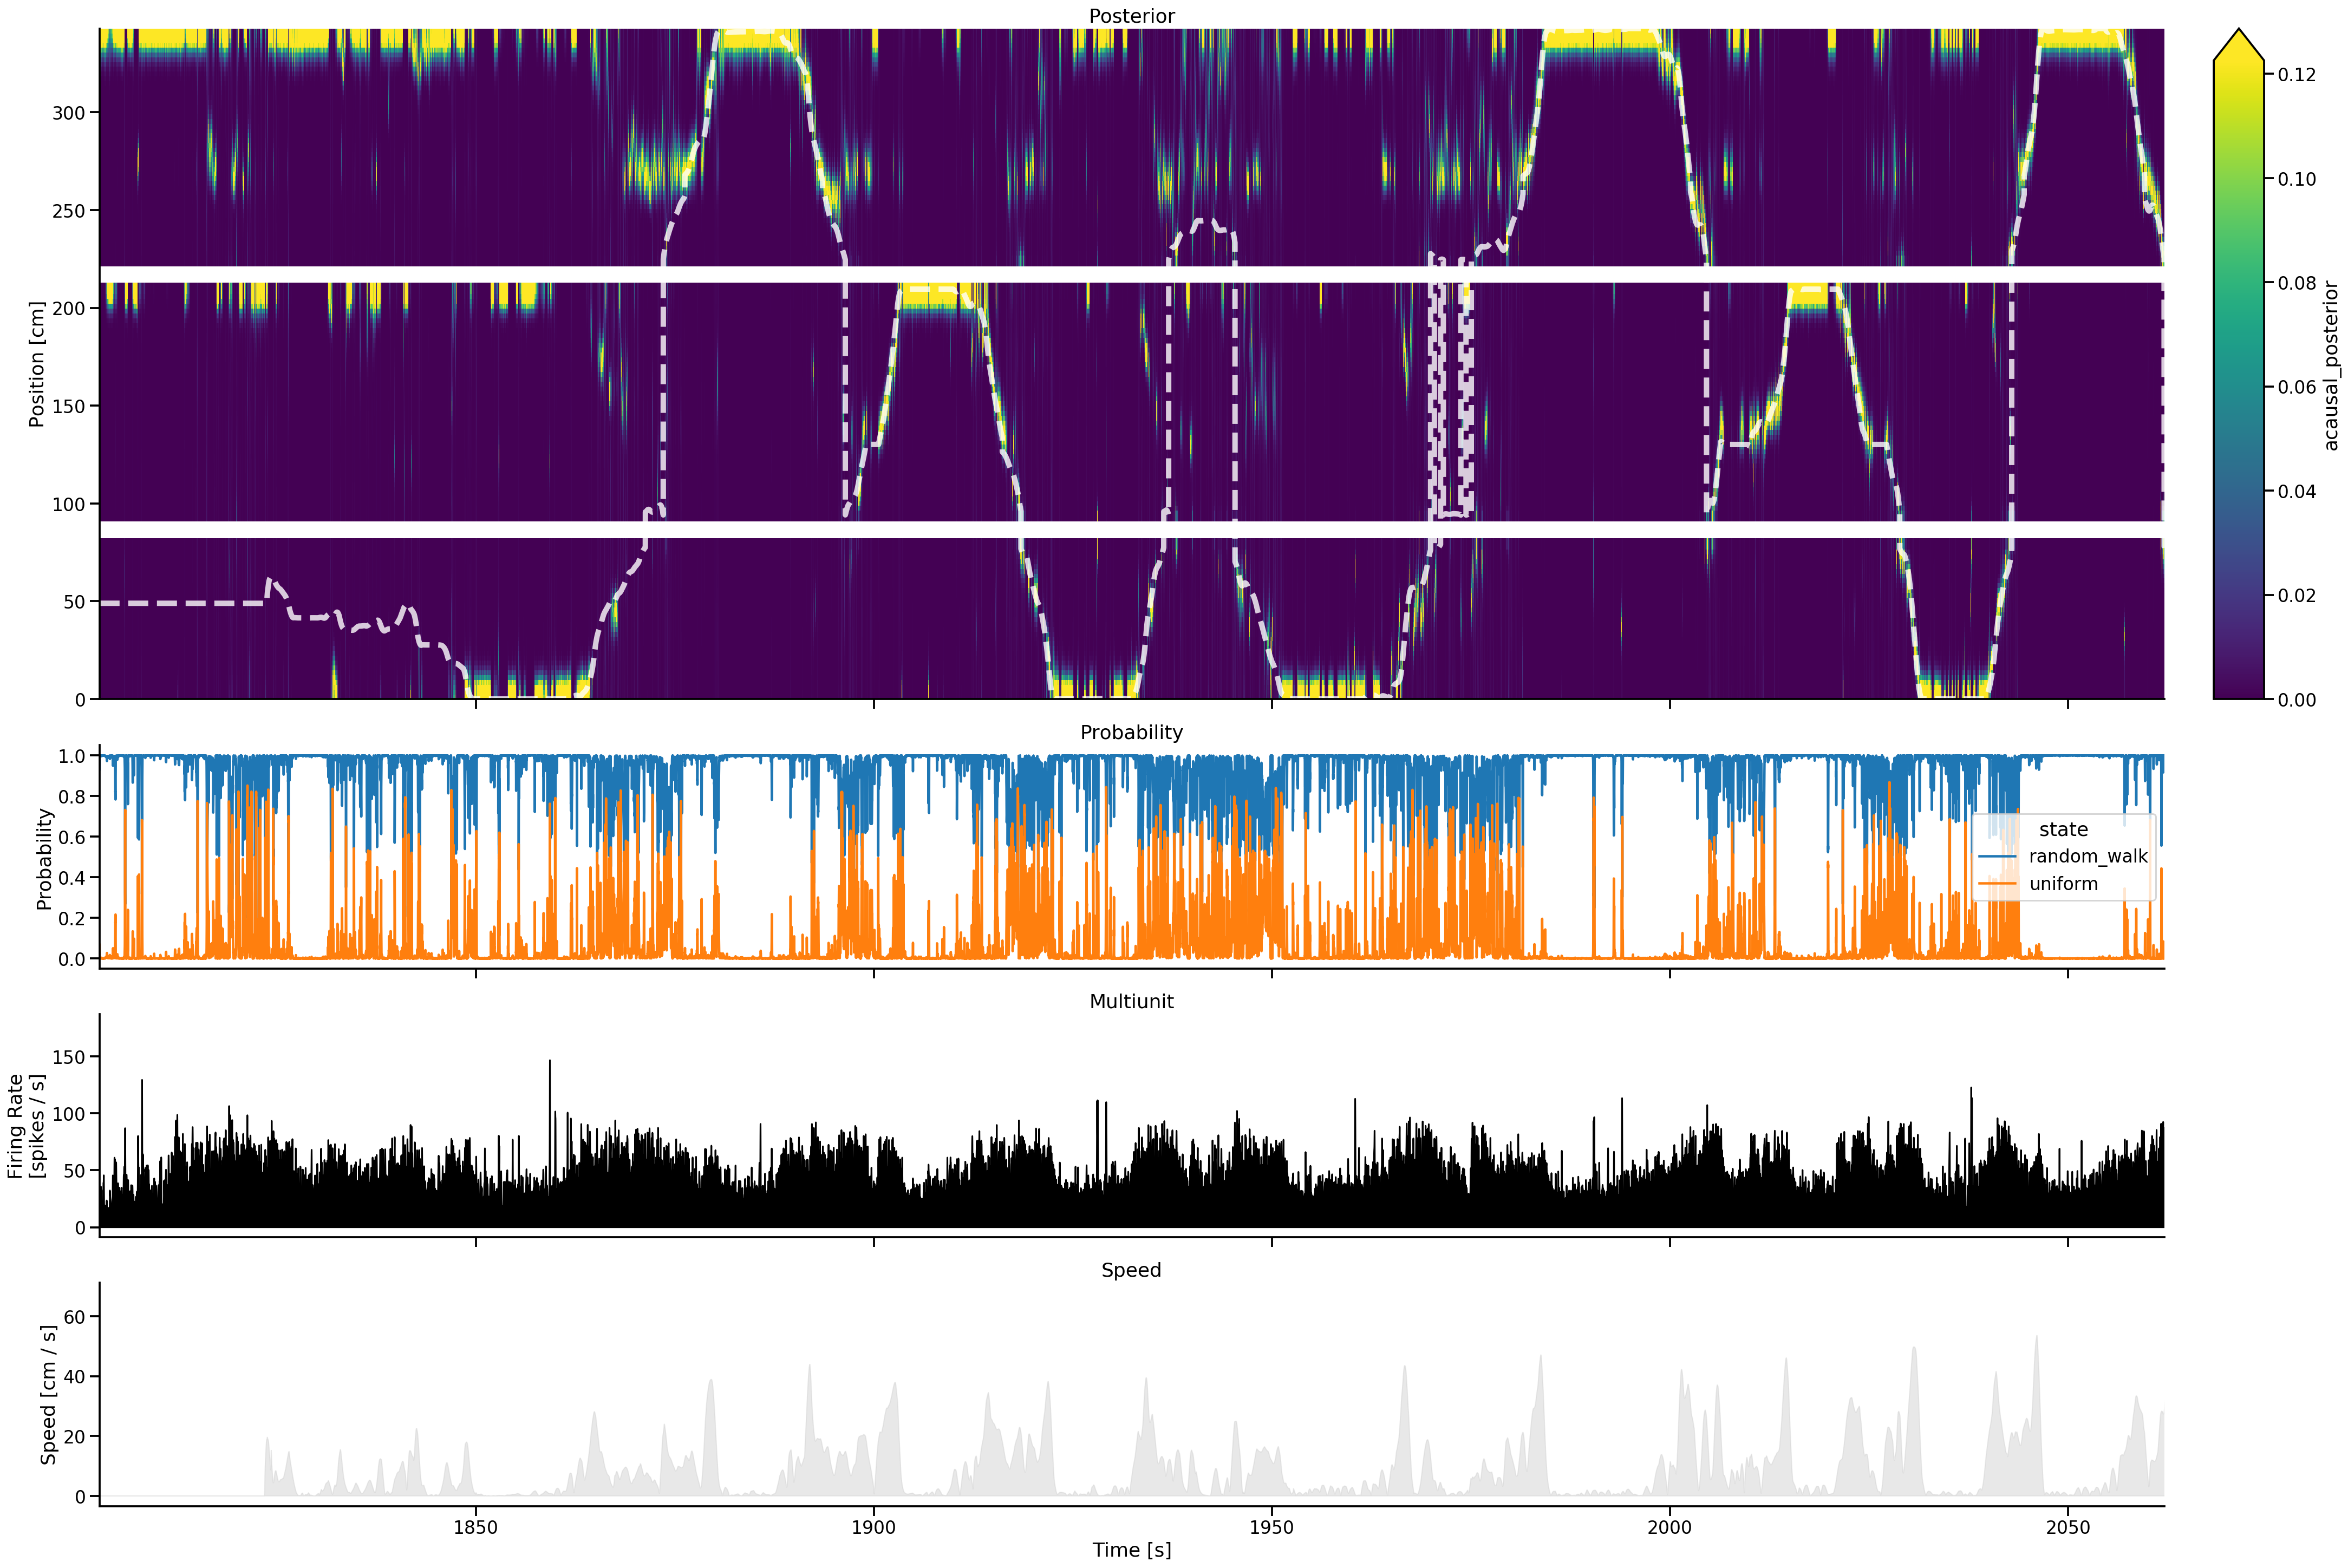

In [54]:
time_slice = slice(0, 500_000)

plot_classifier_time_slice(
    time_slice,
    cv_classifier,
    cv_classifier_clusterless_results[0],
    data,
    posterior_type="acausal_posterior",
    figsize=(30, 20),
)